In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_Leaves",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9123 files belonging to 8 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

In [ ]:
len(dataset)

286

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 6 5 5 3 0 3 1 7 6 7 6 0 7 6 2 6 6 6 6 0 2 1 1 5 0 7 0 1 3 2 7]


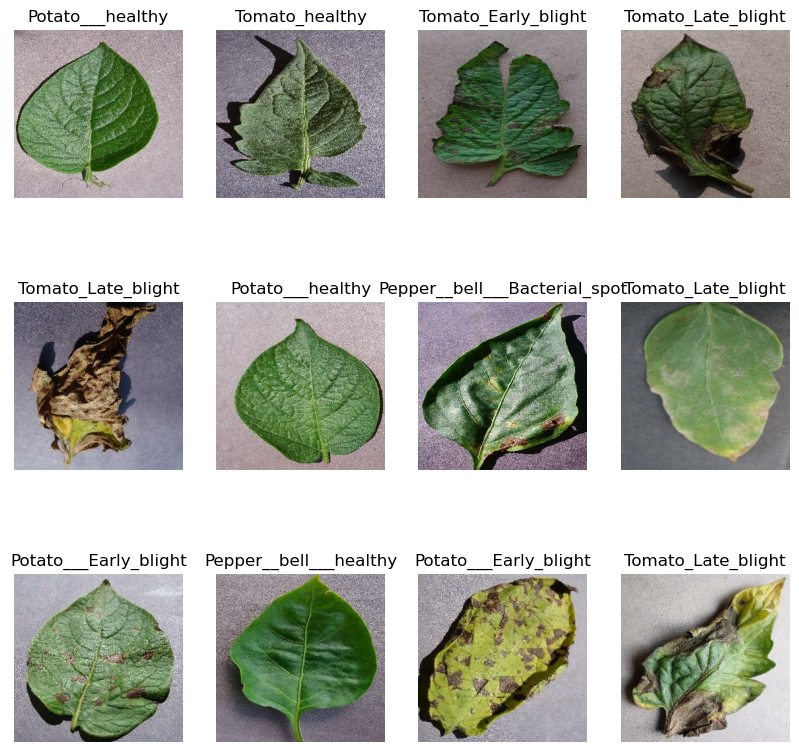

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#dataset splitting
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(228, 28, 30)

In [ ]:
#performance improver of CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
history = loaded_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
228/228 [==============================] - 1085s 5s/step - loss: 0.7369 - accuracy: 0.1110 - val_loss: 0.6523 - val_accuracy: 0.1060
Epoch 2/10
228/228 [==============================] - 910s 4s/step - loss: 0.5329 - accuracy: 0.1148 - val_loss: 0.3742 - val_accuracy: 0.1161
Epoch 3/10
228/228 [==============================] - 662s 3s/step - loss: 0.4524 - accuracy: 0.1101 - val_loss: 0.3298 - val_accuracy: 0.1228
Epoch 4/10
208/228 [==========================>...] - ETA: 47s - loss: 0.3358 - accuracy: 0.1123

In [ ]:
model.save('loaded_model.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('loaded_model.keras')

In [ ]:
loaded_model.save('my_model.h5')

C:\Users\mayan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
scores = loaded_model.evaluate(test_ds)

30/30 [==============================] - 24s 806ms/step - loss: 0.9845 - accuracy: 0.0396


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

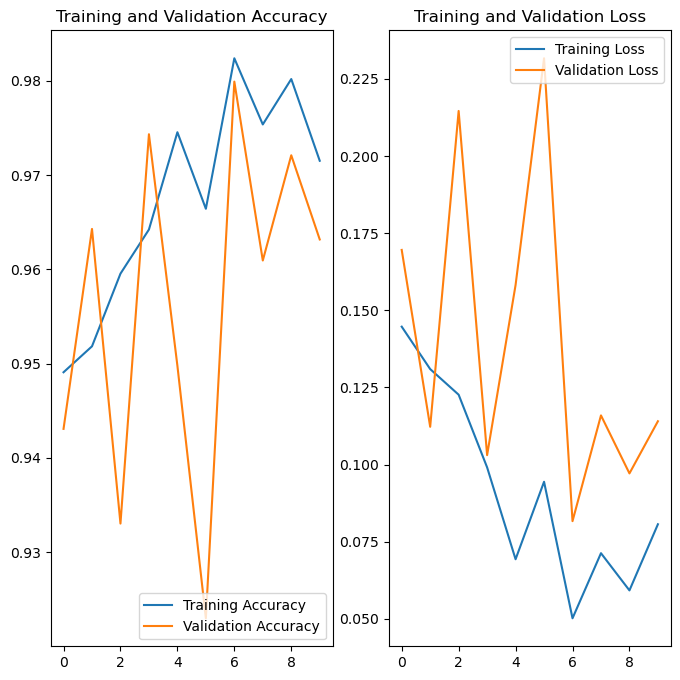

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range (10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 6s 6s/step
predicted label: Potato___Early_blight


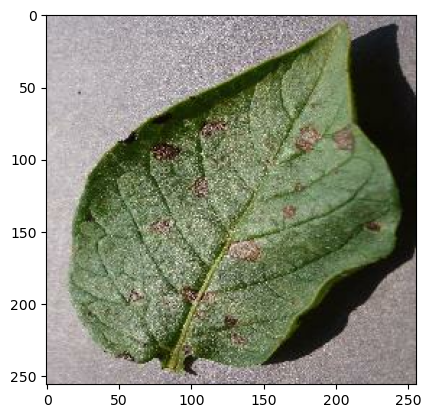

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

 first_image = images_batch[0].numpy().astype('uint8')
 first_label = labels_batch[0].numpy()

 print("first image to predict")
 plt.imshow(first_image)
 print("actual label:", class_names[first_label])

 batch_prediction = loaded_model.predict(images_batch)
 print("predicted label:",class_names[np.argmax(batch_prediction[0])])